In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed.
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# StellarGraph library need to be installed in the environment
from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding
from stellargraph.utils import plot_history
from tensorflow import keras

In [2]:
# Input data files are available in the "./input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory;
import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output;
print(os.getcwd())

['ppi_v.csv', 'ppi_e_train.csv', 'ppi_e_test.csv']
/Users/gweedo/Desktop/NECSTLab/Oracle/Corso Oracle/Fall 2021/high-performance-graph-analytics-2021/graph_ml


In [3]:
# A list of utility functions used below to manipulate/clean data and compute accuracy metrics;

def build_dataframe(input_data: pd.DataFrame, col_name: str, preserve_int_col_name=False) -> pd.DataFrame:
    """
    Given an input DataFrame and a column name, return a new DataFrame in which the column has been cleaned.
    Used to transform features and labels columns from "0;1;1;0" to [0, 1, 1, 0]
    """
    vertices_dict = []
    for i, row_i in input_data.iterrows():
        features = [int(float(x)) for x in row_i[f"{col_name}s"].split(";")]
        
        new_v = {"id": i}
        for j, f in enumerate(features):
            new_v[j if preserve_int_col_name else f"{col_name}_{j}"] = f
        vertices_dict += [new_v]
    res_df = pd.DataFrame(vertices_dict)
    return res_df.set_index("id")

# Taken from old keras source code
def F1_Score(y_true, y_pred): 
    true_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
    predicted_positives = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + keras.backend.epsilon())
    recall = true_positives / (possible_positives + keras.backend.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+keras.backend.epsilon())
    return f1_val

In [4]:
# Define graph name
graph_name = "ppi"

# Read vertex data
vertices_path = f"./input/{graph_name}_v.csv"
vertices = pd.read_csv(vertices_path, sep=",", index_col="id")
vertices.drop(['dataset'], axis=1, inplace=True)
vertices = build_dataframe(vertices, "feature")
vertices.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# Read edges data (training data)
edge_path = f"./input/{graph_name}_e_train.csv"
edges = pd.read_csv(edge_path, sep=",", index_col=None)
edges.head()

,source,dest
0,0,372
1,0,1101
2,0,766
3,1,640
4,1,1


In [6]:
# Build input graph from vertices and edges (training data) dataframes
ppi_graph = StellarGraph(nodes={'protein':vertices}, edges={'interaction':edges}, source_column="source", target_column="dest")
print(ppi_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 56944, Edges: 736845

 Node types:
  protein: [56944]
    Features: float32 vector, length 50
    Edge types: protein-interaction->protein

 Edge types:
    protein-interaction->protein: [736845]
        Weights: all 1 (default)
        Features: none


In [7]:
# Split the input graph into a train and validation graphs 
edge_splitter_valid = EdgeSplitter(ppi_graph)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from ppi_graph, 
# Obtain the reduced graph graph_valid with the sampled links removed
# examples_valid and labels_valid are employed as ground truth for testing the model
graph_valid, examples_valid, labels_valid = edge_splitter_valid.train_test_split(
    p=0.1, method="global", keep_connected=True, seed=42
)
print(graph_valid.info())

** Sampled 73684 positive and 73684 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 56944, Edges: 663161

 Node types:
  protein: [56944]
    Features: float32 vector, length 50
    Edge types: protein-interaction->protein

 Edge types:
    protein-interaction->protein: [663161]
        Weights: all 1 (default)
        Features: none


In [8]:
# Build validation dataframe for explicit visualization
valid_sources = [examples_valid[i][0] for i in range(0,len(examples_valid))]
valid_dests = [examples_valid[i][1] for i in range(0,len(examples_valid))]
valid_df = pd.DataFrame(list(zip(valid_sources, valid_dests, labels_valid)), columns=['source', 'dest', 'label'])
print(valid_df)

        source   dest  label
0        10508  10843      1
1        21261  21645      1
2        22768  23885      1
3        54024  54244      1
4        43264  43832      1
...        ...    ...    ...
147363   22020  18948      0
147364   49962  27528      0
147365   46809  48040      0
147366   27008  56809      0
147367   53362  25649      0

[147368 rows x 3 columns]


In [9]:
# Split the reduced graph into a train and validation graphs 
edge_splitter_train = EdgeSplitter(graph_valid, ppi_graph)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph_valid, 
# Obtain the reduced graph graph_train with the sampled links removed
# examples_train and labels_train are employed as ground truth for training the model
graph_train, examples_train, labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True, seed=42
)

** Sampled 66316 positive and 66316 negative edges. **


In [10]:
# Build training dataframe for explicit visualization
train_sources = [examples_train[i][0] for i in range(0,len(examples_train))]
train_dests = [examples_train[i][1] for i in range(0,len(examples_train))]
train_df = pd.DataFrame(list(zip(train_sources, train_dests, labels_train)), columns=['source', 'dest', 'label'])
print(train_df)

        source   dest  label
0        15903  18065      1
1        35037  35208      1
2        21903  22704      1
3        42403  42627      1
4         7810   7922      1
...        ...    ...    ...
132627    6071  34811      0
132628   38310  44580      0
132629   48917  36083      0
132630    3521  15891      0
132631   40015  45695      0

[132632 rows x 3 columns]


In [11]:
# Set the number of training epochs
epochs = 50

# Create a generator on graph_train and make an iterator over the training links
train_gen = FullBatchLinkGenerator(graph_train, method="gcn")
train_flow = train_gen.flow(examples_train, labels_train)

# Create a generator on graph_valid and make an iterator over the validation links
valid_gen = FullBatchLinkGenerator(graph_valid, method="gcn")
valid_flow = valid_gen.flow(examples_valid, labels_valid)

Using GCN (local pooling) filters...
Using GCN (local pooling) filters...


In [12]:
# Create a GCN model
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

# Expose input and output tensors of the GCN model for link prediction
x_inp, x_out = gcn.in_out_tensors()

# Create the final link embedding layer: 
# - it takes a pair of node embeddings produced by the GCN model, 
# - applies a binary operator (ip = inner product) to produce the corresponding link embedding,
# - passes it through a dense layer (if method!="ip") to obtain the wanted embedding dimension
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

# Reshape the predictions from (X, 1) to (X,) to match the shape of targets
prediction = keras.layers.Reshape((-1,))(prediction)

# Stack the GCN and prediction layers into a Keras model
model = keras.Model(inputs=x_inp, outputs=prediction)

# Compile the model, specifying the hyperparameters
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.BinaryAccuracy(), F1_Score],
)

In [13]:
# Evaluate the initial (untrained) model on the train and validation sets: 
init_train_metrics = model.evaluate(train_flow)
init_valid_metrics = model.evaluate(valid_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_valid_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 140ms/step - loss: 3.2201 - binary_accuracy: 0.5000 - F1_Score: 0.0000e+00

Train Set Metrics of the initial (untrained) model:
	loss: 3.2037
	binary_accuracy: 0.5000
	F1_Score: 0.0000

Validation Set Metrics of the initial (untrained) model:
	loss: 3.2201
	binary_accuracy: 0.5000
	F1_Score: 0.0000


In [14]:
# Train the model
history = model.fit(
    train_flow, epochs=epochs, validation_data=valid_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 1s - loss: 3.0997 - binary_accuracy: 0.5000 - F1_Score: 9.0472e-05 - val_loss: 2.1517 - val_binary_accuracy: 0.5000 - val_F1_Score: 2.7143e-05
Epoch 2/50
1/1 - 0s - loss: 2.1163 - binary_accuracy: 0.5000 - F1_Score: 1.5078e-04 - val_loss: 1.5765 - val_binary_accuracy: 0.5000 - val_F1_Score: 8.1425e-05
Epoch 3/50
1/1 - 0s - loss: 1.5559 - binary_accuracy: 0.5000 - F1_Score: 1.8094e-04 - val_loss: 1.1690 - val_binary_accuracy: 0.5004 - val_F1_Score: 0.0016
Epoch 4/50
1/1 - 0s - loss: 1.1577 - binary_accuracy: 0.5004 - F1_Score: 0.0017 - val_loss: 0.8582 - val_binary_accuracy: 0.5141 - val_F1_Score: 0.0571
Epoch 5/50
1/1 - 0s - loss: 0.8525 - binary_accuracy: 0.5158 - F1_Score: 0.0651 - val_loss: 0.6353 - val_binary_accuracy: 0.6180 - val_F1_Score: 0.4008
Epoch 6/50
1/1 - 0s - loss: 0.6398 - binary_accuracy: 0.6189 - F1_Score: 0.4062 - val_loss: 0.5631 - val_binary_accuracy: 0.7513 - val_F1_Score: 0.7172
Epoch 7/50
1/1 - 0s - loss: 0.5719 - binary_accuracy: 0.7431 - F1_Sc

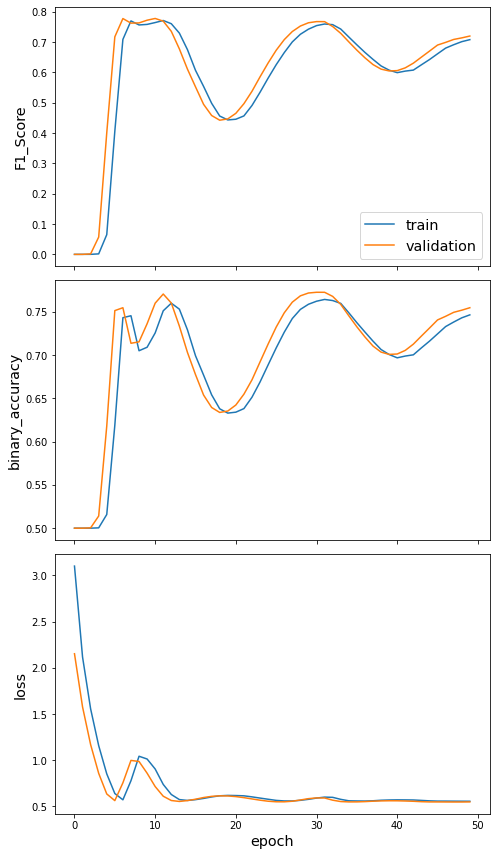

In [15]:
# Plot the training history
plot_history(history)

In [16]:
# Evaluate the trained model on the train and validation sets: 
train_metrics = model.evaluate(train_flow)
valid_metrics = model.evaluate(valid_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nValidation Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, valid_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 143ms/step - loss: 0.5491 - binary_accuracy: 0.7546 - F1_Score: 0.7198

Train Set Metrics of the trained model:
	loss: 0.5537
	binary_accuracy: 0.7487
	F1_Score: 0.7119

Validation Set Metrics of the trained model:
	loss: 0.5491
	binary_accuracy: 0.7546
	F1_Score: 0.7198


In [17]:
# Read edges data (test data)
edge_path = f"./input/{graph_name}_e_test.csv"
edges_test = pd.read_csv(edge_path, sep=",", index_col=None)
edges_test.head()

# Extract numpy arrays for test examples
examples_test = edges_test.to_numpy()

In [18]:
# Create a generator on ppi_graph and make an iterator over the test links
test_gen = FullBatchLinkGenerator(ppi_graph, method="gcn")
test_flow = test_gen.flow(examples_test)

# Compute the predictions for the edges in the test set
y_pred = model.predict(test_flow)
y_pred = keras.backend.round(keras.backend.clip(y_pred, 0, 1)).numpy()

# Attach the predictions to the test dataframe, then save it as the final output file 
y_pred_df = pd.DataFrame(np.transpose(y_pred), columns=['prediction'])
output = pd.concat([edges_test, y_pred_df], axis=1)
output.to_csv(f"sample_{graph_name}_predictions.csv", index=False)
print(output)

Using GCN (local pooling) filters...
        source   dest  prediction
0        29842  56942         0.0
1        19107  10249         1.0
2        53567  20998         0.0
3        51834  54178         0.0
4         8316   8730         0.0
...        ...    ...         ...
327479   54041   5997         0.0
327480   55786  56466         0.0
327481   26042   1490         0.0
327482   15526  56029         0.0
327483   31881  18727         0.0

[327484 rows x 3 columns]
